# Example of discrete and inverse discrete Fourier transform

In [1]:
import dask.array
import matplotlib.pyplot as plt
import numpy as np
import numpy.fft as npft
import numpy.testing as npt
import xarray as xr
import xrft
from scipy import signal

plt.rcParams.update({"figure.autolayout": True})

%matplotlib inline

In this notebook, we provide examples of the discrete Fourier transform (DFT) and its inverse, and how `xrft` automatically harnesses the metadata. We compare the results to conventional `numpy.fft` (hereon `npft`) routines to highlight the strengths of `xrft`.

## A case with synthetic data

### Generate synthetic data centered around zero

In [2]:
k0 = 1/0.52
T = 4.
dx = 0.02

x = np.arange(-2*T, 2*T, dx) 
y = np.cos(2*np.pi*k0*x) 
y[np.abs(x) > T/2] = 0

da = xr.DataArray(y, dims=('x',), coords={'x': x})

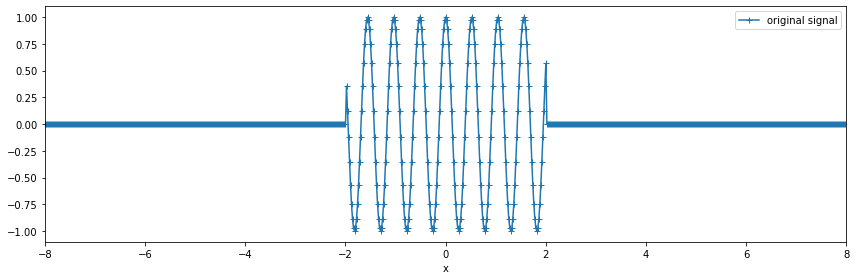

In [3]:
fig, ax = plt.subplots(figsize=(12, 4)) 
da.plot(ax=ax, marker='+', label='original signal')
ax.legend()
ax.set_xlim((-8, 8));

**Let's take the Fourier transform**

We will compare the Fourier transform with and without taking into consideration about the phase information.

In [4]:
# Fourier Transform w/ consideration of phase
da_dft = xrft.fft(da, true_phase=True, true_amplitude=True)

# Fourier Transform w/ numpy.fft-like behavior
da_fft = xrft.fft(da)

# With numpy.fft
da_npft = npft.fft(da)

c:\users\zmoon\git\xrft\xrft\xrft.py:352: FutureWarning: Flags true_phase and true_amplitude will be set to True in future versions of xrft.fft to preserve the theoretical phasing and amplitude of Inverse Fourier Transform. Consider setting them to ensure future compatibility with numpy.fft.fft-like behavior and to deactivate this warning.
  warnings.warn(msg, FutureWarning)


In [5]:
k = da_dft.freq_x  # Wavenumber axis

# Theoretical result of the Fourier transform
TF_s = T/2 * (np.sinc(T * (k - k0)) + np.sinc(T * (k + k0)))

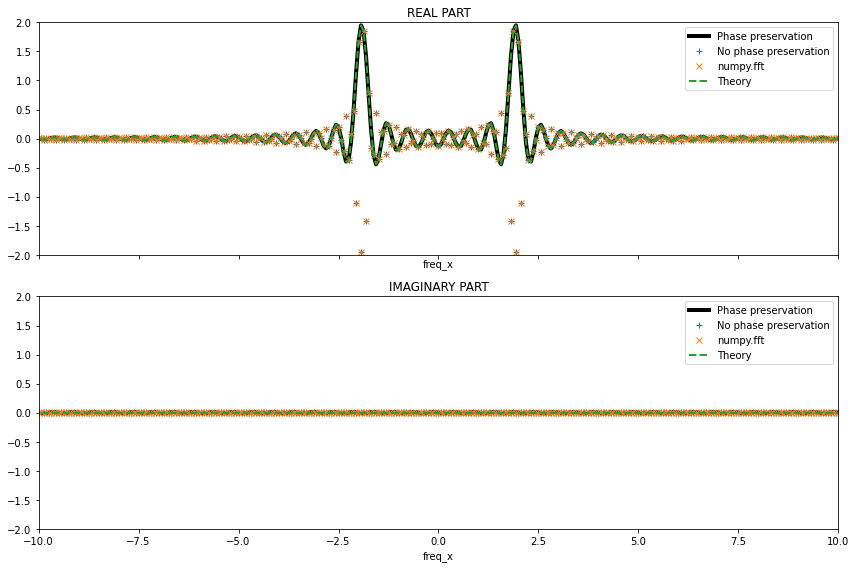

In [6]:
fig, (ax1, ax2) = plt.subplots(figsize=(12, 8), nrows=2, ncols=1, sharex=True, sharey=True)

(da_dft.real).plot(ax=ax1, ls='-', lw=4, c='k', label='Phase preservation') 
((da_fft*dx).real).plot(ax=ax1, ls='', marker='+', label='No phase preservation') 
ax1.plot(k, (npft.fftshift(da_npft)*dx).real, 'x', label='numpy.fft')
ax1.plot(k, TF_s.real, '--', lw=2, label='Theory')
ax1.set_xlim((-10, 10))
ax1.set_ylim((-2, 2))
ax1.legend()
ax1.set_title('REAL PART')

(da_dft.imag).plot(ax=ax2, ls='-', lw=4, c='k', label='Phase preservation') 
((da_fft*dx).imag).plot(ax=ax2, ls='', marker='+', label='No phase preservation') 
ax2.plot(k, (npft.fftshift(da_npft)*dx).imag, 'x', label='numpy.fft')
ax2.plot(k, TF_s.imag, '--', lw=2, label='Theory')
ax2.legend()
ax2.set_title('IMAGINARY PART');

`xrft.fft` with phase preservation settings, `xrft.fft` with default settings, and `npft.fft` with careful `npft.fftshift`ing all give the same amplitudes as theory (as the coordinates of the original data was centered), but the latter two get the sign wrong due to losing the phase information. It is perhaps worth noting that the latter two (`xrft.fft` with default settings and `npft.fft`) require the amplitudes to be multiplied by $dx$ to be consistent with theory while `xrft.fft` can automatically take care of this with the flag `true_amplitude=True`:
$$\mathcal{F}(da)(f) = \int_{-\infty}^{+\infty}da(x)e^{-2\pi ifx} dx
\\
\rightarrow
\text{xrft.fft}(da)(f[m]) = \sum_n da(x[n]) e^{-2\pi i f[m] x[n]} \Delta x$$

**Perform the inverse transform**

In [7]:
# Signal in direct space
ida_dft = xrft.ifft(da_dft, true_phase=True, true_amplitude=True)
ida_fft = xrft.ifft(da_fft)

c:\users\zmoon\git\xrft\xrft\xrft.py:589: FutureWarning: Default idft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute 'direct_lag', defaulting to zero if that attribute is not set.
  warnings.warn(msg, FutureWarning)
c:\users\zmoon\git\xrft\xrft\xrft.py:560: FutureWarning: Flags true_phase and true_amplitude will be set to True in future versions of xrft.ifft to preserve the theoretical phasing and amplitude of Inverse Fourier Transform. Consider setting them to ensure future compatibility with numpy.fft.ifft-like behavior and to deactivate this warning.
  warnings.warn(msg, FutureWarning)
c:\users\zmoon\git\xrft\xrft\xrft.py:589: FutureWarning: Default idft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute 'direct_lag', defaulting to zero if that attribute is not set.
  warnings.warn(msg, FutureW

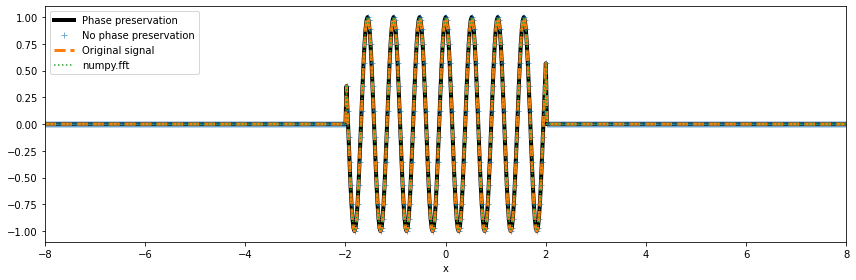

In [8]:
fig, ax = plt.subplots(figsize=(12, 4))
ida_dft.real.plot(ax=ax, ls='-', c='k', lw=4, label='Phase preservation')
ax.plot(x, ida_fft.real, '+', label='No phase preservation', alpha=.6)
da.plot(ax=ax, ls='--', lw=3, label='Original signal')
ax.plot(x, npft.ifft(da_npft).real, ':', label='numpy.fft')
ax.set_xlim((-8, 8))
ax.legend(loc='upper left');

Although `xrft.ifft` with default settings misses the amplitude scaling (viz. resolution in wavenumber or frequency), since it is the inverse of the Fourier transform uncorrected for $dx$, the result becomes consistent with `xrft.ifft` with phase-preservation settings. In other words, `xrft.fft` (and `npft.fft`) misses the $dx$ scaling and `xrft.ifft` (and `npft.ifft`) misses the $df\ (=1/(N\times dx))$ scaling. When applying the two operators in conjuction by doing `ifft(fft())`, there is a $1/N\ (=dx\times df)$ factor missing which is, in fact, [arbitrarily included in the `ifft` definition as a normalization factor](https://numpy.org/doc/stable/reference/routines.fft.html#module-numpy.fft).
By incorporating the right scalings in `xrft.dft` and `xrft.idft`, there is no more consideration of the number of data points ($N$):
$$\mathcal{F}^{-1}(\mathcal{F}(da))(x) = \frac{1}{2\pi}\int_{-\infty}^{+\infty}\mathcal{F}(da)(f)e^{2\pi ifx} df
\\
\rightarrow
\text{xrft.ifft}(\text{xrft.fft}(da))(x[n]) = \sum_m \text{xrft.fft}(da)(f[m]) e^{2\pi i f[m] x[n]} \Delta f$$

### Synthetic data not centered around zero

**Now let's shift the coordinates so that they are not centered.**

**This is where the `xrft` magic happens.** With the relevant flags, `xrft`'s FFT can preserve information about the data's location in its original space. This information is not preserved in a `numpy.fft` Fourier transform. This section demonstrates how to preserve this information using the `true_phase=True`, `true_amplitude=True` flags.

In [9]:
nshift = 70
x0 = dx*nshift 
nda = da.shift(x=nshift).dropna('x')

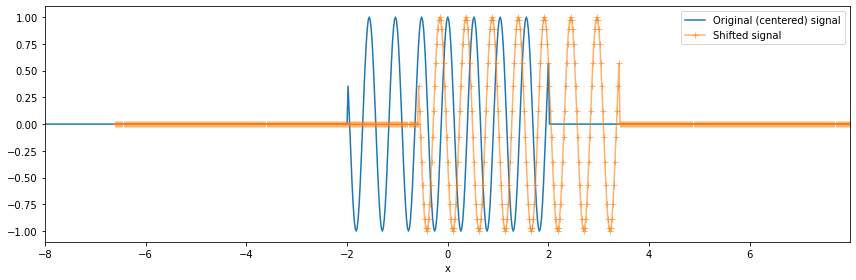

In [10]:
fig, ax = plt.subplots(figsize=(12,4))
da.plot(ax=ax, label='Original (centered) signal') 
nda.plot(ax=ax, marker='+', label='Shifted signal', alpha=.6) 
ax.set_xlim((-8, nda.x.max()))
ax.legend();

**We consider again the Fourier transform.**

In [11]:
# Fourier Transform w/ phase preservation
nda_dft = xrft.fft(nda, true_phase=True, true_amplitude=True)

# Fourier Transform w/out phase preservation
nda_fft = xrft.fft(nda)

# With numpy.fft
nda_npft = npft.fft(nda)

c:\users\zmoon\git\xrft\xrft\xrft.py:352: FutureWarning: Flags true_phase and true_amplitude will be set to True in future versions of xrft.fft to preserve the theoretical phasing and amplitude of Inverse Fourier Transform. Consider setting them to ensure future compatibility with numpy.fft.fft-like behavior and to deactivate this warning.
  warnings.warn(msg, FutureWarning)


In [12]:
nk = nda_dft.freq_x  # Wavenumber axis

# Theoretical FT (note the additional phase)
TF_ns = T/2 * (np.sinc(T * (nk - k0)) + np.sinc(T * (nk + k0))) * np.exp(-2j*np.pi*nk*x0)

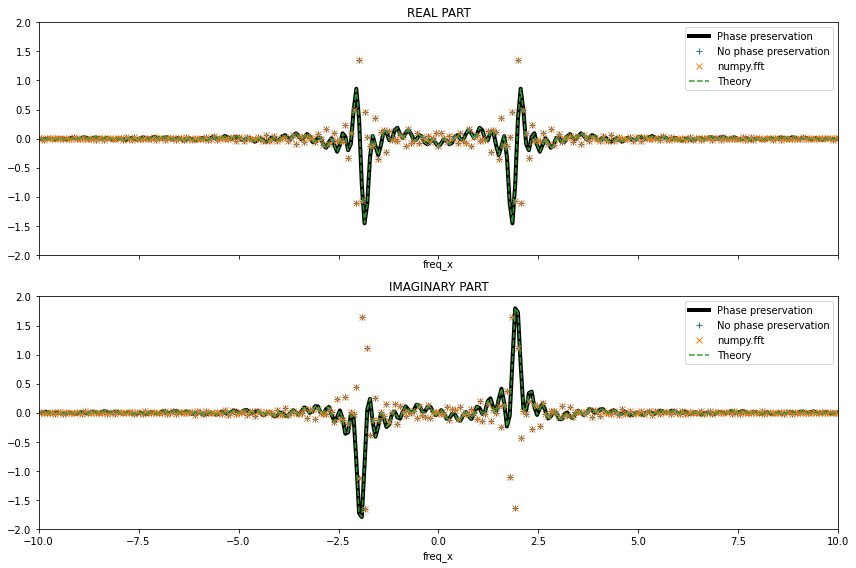

In [13]:
fig, (ax1, ax2) = plt.subplots(figsize=(12, 8), nrows=2, ncols=1, sharex=True, sharey=True)

(nda_dft.real).plot(ax=ax1, ls='-', lw=4, c='k', label='Phase preservation') 
((nda_fft*dx).real).plot(ax=ax1, ls='', marker='+',label='No phase preservation')
ax1.plot(nk, (npft.fftshift(nda_npft)*dx).real, 'x', label='numpy.fft')
ax1.plot(nk, TF_ns.real, '--', label='Theory')
ax1.set_xlim((-10, 10))
ax1.set_ylim((-2., 2))
ax1.legend()
ax1.set_title('REAL PART')

(nda_dft.imag).plot(ax=ax2, ls='-', lw=4, c='k', label='Phase preservation') 
((nda_fft*dx).imag).plot(ax=ax2, ls='', marker='+', label='No phase preservation') 
ax2.plot(nk, (npft.fftshift(nda_npft)*dx).imag, 'x', label='numpy.fft')
ax2.plot(nk, TF_ns.imag, '--', label='Theory')
ax2.legend()
ax2.set_title('IMAGINARY PART');

The expected additional phase (i.e., the complex term; $e^{-i2\pi kx_0}$) that appears in theory is retrieved with `xrft.dft` but not with `xrft.fft` nor `npft.fft`. This is because in `npft.fft` the input data is expected to be centered around zero. **In the current version of `xrft`, the behavior of `xrft.fft` defaults to this as well, so set the flags `true_phase=True` and `true_amplitude=True` in order to obtain results matching with theory.**

**Now, let's take the inverse transform.**

In [14]:
# Signal in direct space
inda_dft = xrft.ifft(nda_dft, true_phase=True, true_amplitude=True)
inda_fft = xrft.ifft(nda_fft)

c:\users\zmoon\git\xrft\xrft\xrft.py:589: FutureWarning: Default idft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute 'direct_lag', defaulting to zero if that attribute is not set.
  warnings.warn(msg, FutureWarning)
c:\users\zmoon\git\xrft\xrft\xrft.py:560: FutureWarning: Flags true_phase and true_amplitude will be set to True in future versions of xrft.ifft to preserve the theoretical phasing and amplitude of Inverse Fourier Transform. Consider setting them to ensure future compatibility with numpy.fft.ifft-like behavior and to deactivate this warning.
  warnings.warn(msg, FutureWarning)
c:\users\zmoon\git\xrft\xrft\xrft.py:589: FutureWarning: Default idft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute 'direct_lag', defaulting to zero if that attribute is not set.
  warnings.warn(msg, FutureW

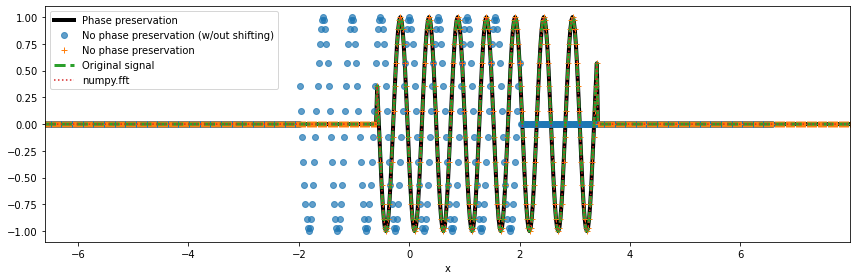

In [15]:
fig, ax = plt.subplots(figsize=(12, 4))
inda_dft.real.plot(ax=ax, ls='-', c='k', lw=4, label='Phase preservation')
ax.plot(x[:len(inda_fft.real)], inda_fft.real, 'o', alpha=.7, 
        label='No phase preservation (w/out shifting)')
ax.plot(x[nshift:], inda_fft.real, '+', label='No phase preservation')
nda.plot(ax=ax, ls='--', lw=3, label='Original signal')
ax.plot(x[nshift:], npft.ifft(nda_npft).real, ':', label='numpy.fft')
ax.set_xlim((nda.x.min(), nda.x.max()))
ax.legend(loc='upper left');

Note that we are only able to match the inverse transforms of `xrft.ifft` and `npft.ifft` to the data `nda` because we "know" the original data `da` was shifted by `nshift` datapoints as we see in `x[nshift:]` (compare the blue dots and orange crosses where, without the knowledge of the shift, we assume that the data were centered around zero). **Using `xrft.ifft` along with `xrft.fft` with the flags `true_phase=True` and `true_amplitude=True` automatically takes care of the information of shifted coordinates.**

## A case with real data

Load atmospheric temperature from the NMC reanalysis.

In [16]:
da = xr.tutorial.open_dataset("air_temperature").air.isel(time=0)
da

<xarray.DataArray 'air' (lat: 25, lon: 53)>
array([[241.2    , 242.5    , 243.5    , ..., 232.79999, 235.5    , 238.59999],
       [243.79999, 244.5    , 244.7    , ..., 232.79999, 235.29999, 239.29999],
       [250.     , 249.79999, 248.89   , ..., 233.2    , 236.39   , 241.7    ],
       ...,
       [296.6    , 296.19998, 296.4    , ..., 295.4    , 295.1    , 294.69998],
       [295.9    , 296.19998, 296.79   , ..., 295.9    , 295.9    , 295.19998],
       [296.29   , 296.79   , 297.1    , ..., 296.9    , 296.79   , 296.6    ]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
    time     datetime64[ns] 2013-01-01
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

In [17]:
Fda = xrft.fft(da, dim="lat", true_phase=True, true_amplitude=True)
Fda

<xarray.DataArray (freq_lat: 25, lon: 53)>
array([[ 55.72721061-46.86182115j,  54.88410513-45.81648436j,
         54.44861105-45.4792758j , ...,  63.78368643-52.78354988j,
         60.99712143-50.28091047j,  57.94756055-48.51852927j],
       [-38.90906614-66.9663849j , -38.90038095-67.92497252j,
        -38.544492  -68.17925905j, ..., -41.94737401-74.09175983j,
        -40.00936528-70.47655747j, -39.05651073-68.04032158j],
       [-77.82019891+12.50876021j, -79.02288653+10.06164636j,
        -80.34175059 +9.81548668j, ..., -86.83039434+26.4819109j ,
        -84.02694401+23.31755583j, -81.26451369+21.4268003j ],
       ...,
       [-77.82019891-12.50876021j, -79.02288653-10.06164636j,
        -80.34175059 -9.81548668j, ..., -86.83039434-26.4819109j ,
        -84.02694401-23.31755583j, -81.26451369-21.4268003j ],
       [-38.90906614+66.9663849j , -38.90038095+67.92497252j,
        -38.544492  +68.17925905j, ..., -41.94737401+74.09175983j,
        -40.00936528+70.47655747j, -39.05651073+68.04032158j],
       [ 55.72721061+46.86182115j,  54.88410513+45.81648436j,
         54.44861105+45.4792758j , ...,  63.78368643+52.78354988j,
         60.99712143+50.28091047j,  57.94756055+48.51852927j]])
Coordinates:
  * lon       (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
    time      datetime64[ns] 2013-01-01
  * freq_lat  (freq_lat) float64 -0.192 -0.176 -0.16 -0.144 ... 0.16 0.176 0.192

The coordinate metadata is lost during the DFT (or any Fourier transform). However, `xrft.fft` preserves the original `lag` in the `direct_lag` attribute of the new `freq_lat` coordinate. The original latitudes are centered around 45&deg;. We could instead pass `lag=45` manually.

In [18]:
iFda = xrft.ifft(Fda, dim="freq_lat", true_phase=True, true_amplitude=True)
iFda

c:\users\zmoon\git\xrft\xrft\xrft.py:589: FutureWarning: Default idft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute 'direct_lag', defaulting to zero if that attribute is not set.
  warnings.warn(msg, FutureWarning)


<xarray.DataArray (lat: 25, lon: 53)>
array([[296.29000854-2.03692639e-15j, 296.79000854-1.57260115e-15j,
        297.1000061 +9.03196374e-16j, ..., 296.8999939 +2.20263432e-15j,
        296.79000854+2.90702812e-15j, 296.6000061 +2.20980508e-15j],
       [295.8999939 -8.88584270e-16j, 296.19998169-3.39575537e-15j,
        296.79000854+5.61674624e-16j, ..., 295.8999939 -2.38676620e-15j,
        295.8999939 +1.24770331e-15j, 295.19998169+7.24456203e-16j],
       [296.6000061 +2.01993645e-15j, 296.19998169+1.97610868e-15j,
        296.3999939 -9.88054338e-16j, ..., 295.3999939 -9.94589070e-16j,
        295.1000061 -1.54617942e-15j, 294.69998169+2.49523612e-15j],
       ...,
       [250.        +1.48534887e-15j, 249.79998779+3.91026468e-15j,
        248.88999939-1.95513234e-15j, ..., 233.19999695-1.29608207e-16j,
        236.38999939-2.72809988e-16j, 241.69999695+2.26693997e-15j],
       [243.79998779-3.00722368e-17j, 244.5       -3.36123551e-15j,
        244.69999695-5.82693719e-17j, ..., 232.79998779+2.19593359e-15j,
        235.29998779+8.21315052e-16j, 239.29998779-9.67078004e-16j],
       [241.19999695-3.03635842e-15j, 242.5       -8.07397560e-16j,
        243.5       +6.76246713e-16j, ..., 232.79998779+2.36408527e-15j,
        235.5       +3.10286712e-15j, 238.59999084+1.36864817e-15j]])
Coordinates:
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
    time     datetime64[ns] 2013-01-01
  * lat      (lat) float64 15.0 17.5 20.0 22.5 25.0 ... 65.0 67.5 70.0 72.5 75.0

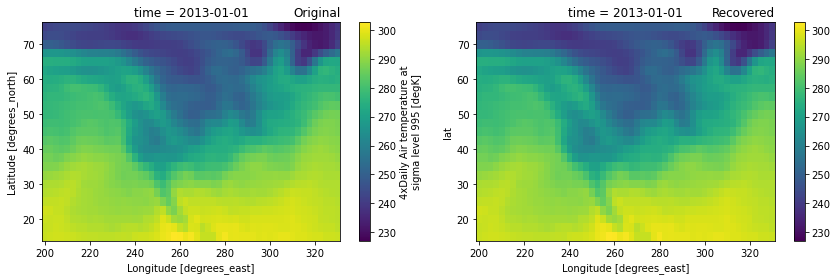

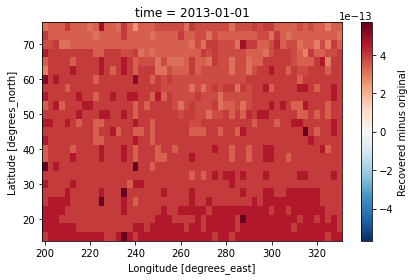

In [19]:
fig, (ax1, ax2) = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)

da.plot(ax=ax1)
ax1.set_title("Original", loc="right")

iFda.real.plot(ax=ax2)
ax2.set_title("Recovered", loc="right")

(iFda.real.assign_coords(lat=da.lat[::-1]) - da).plot(
    size=4, center=0, cbar_kwargs=dict(label="Recovered minus original")
);
# ^ In `iFda`, latitudes are reversed, and float64 instead of float32,
#   so in a normal subtraction (without the `.assign_coords`),
#   only a few latitude values match.

We see the inverse DFT of the Fourier transformed original temperature data returns the original data to within float64 floating point rounding error.